# A/B Testing

Cookie Cats is a hugely popular mobile puzzle game developed by Tactile Entertainment. It's a classic "connect three" style puzzle game where the player must connect tiles of the same color in order to clear the board and win the level. 

As players progress through the game they will encounter gates that force them to wait some time before they can progress or make an in-app purchase. In this project, we will analyze the result of an A/B test where the first gate in Cookie Cats was moved from level 30 to level 40. In particular, we will analyze the impact on player retention and game rounds.

In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import os

from scipy.stats import shapiro
import scipy.stats as stats

import warnings
warnings.filterwarnings("ignore")

c:\Users\valer\AppData\Local\Programs\Python\Python39\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [11]:
data = pd.read_csv("cookie_cats.csv")

data.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [3]:
data.dtypes

userid             int64
version           object
sum_gamerounds     int64
retention_1         bool
retention_7         bool
dtype: object

In [4]:
data.shape

(90189, 5)

The data is from 90,189 players that installed the game while the AB-test was running. The variables are:

- *userid* - a unique number that identifies each player.
- *version* - whether the player was put in the control group (gate_30 - a gate at level 30) or the test group (gate_40 - a gate at level 40).
- *sum_gamerounds* - the number of game rounds played by the player during the first week after installation
- *retention_1* - did the player come back and play 1 day after installing?
- *retention_7* - did the player come back and play 7 days after installing?

When a player installed the game, he or she was randomly assigned to either gate_30 or gate_40.

Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)



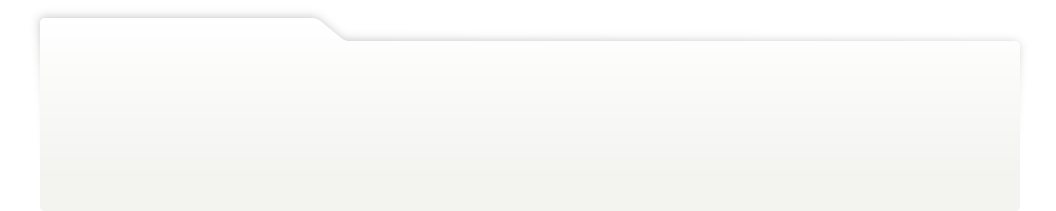
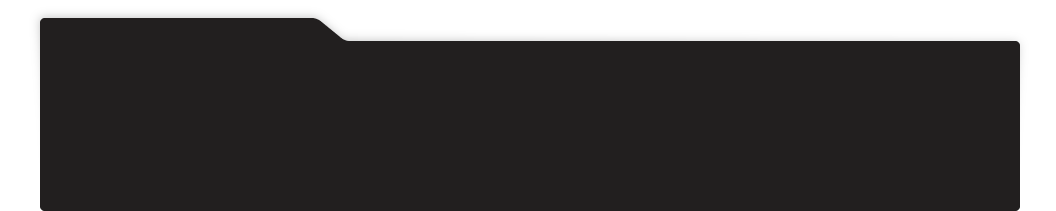
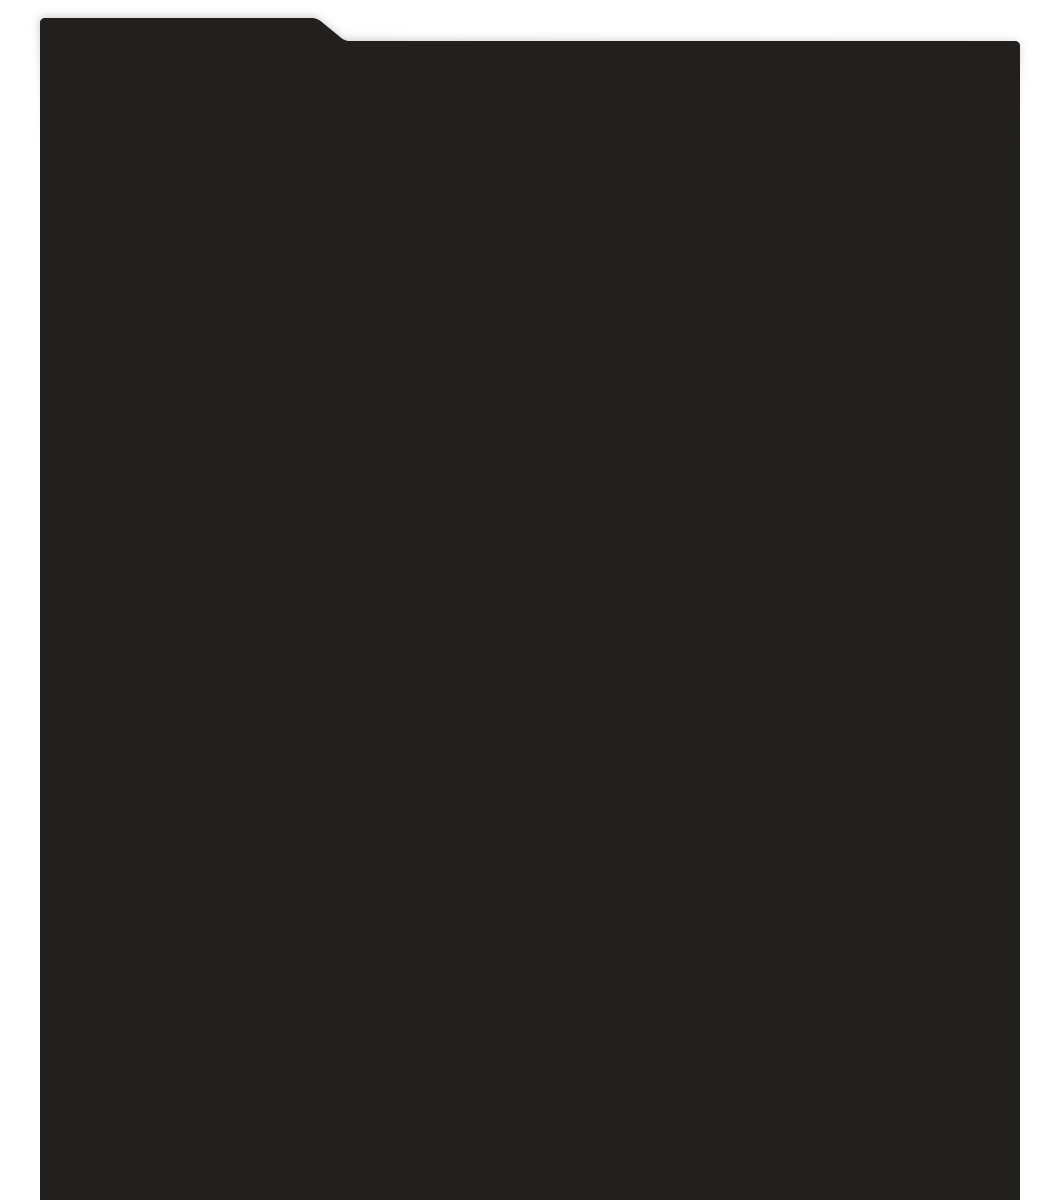
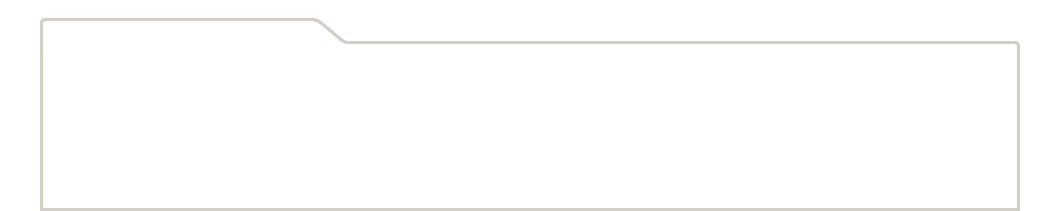
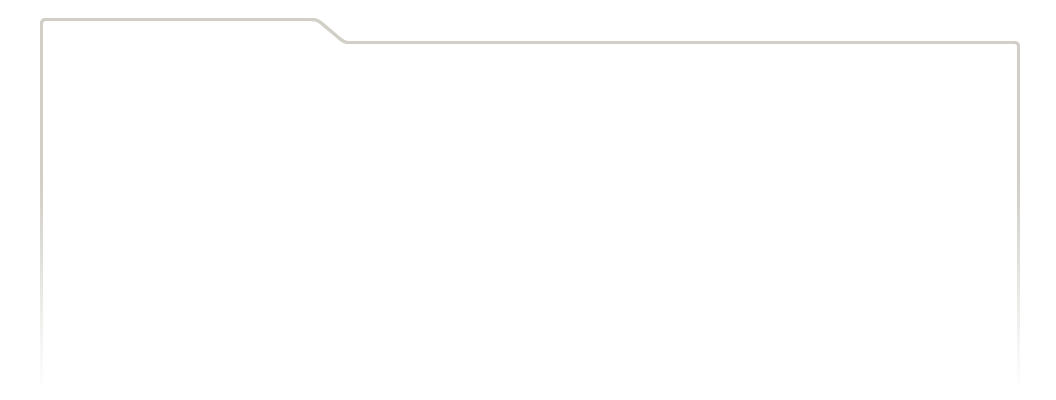
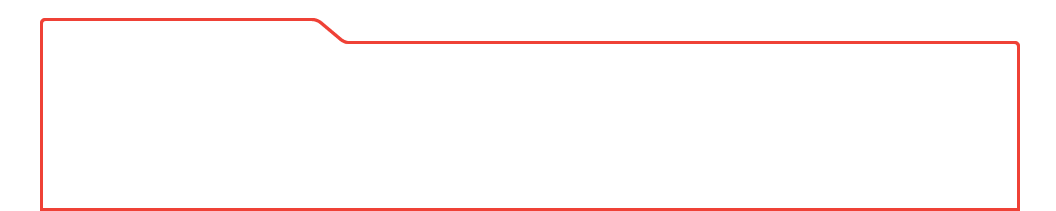
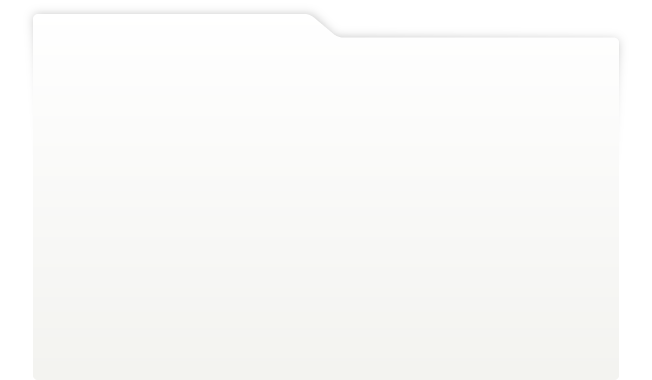
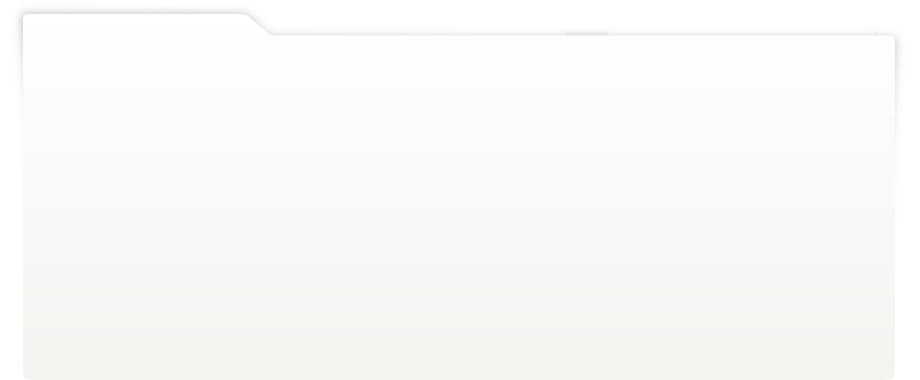
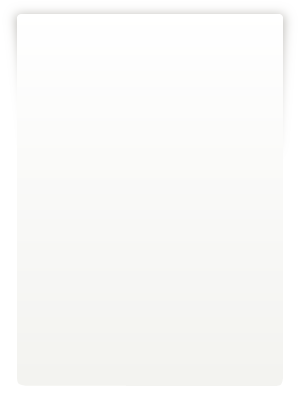
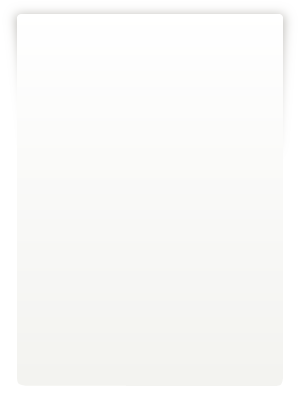
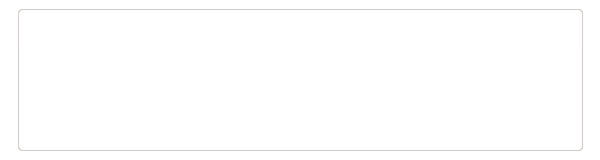
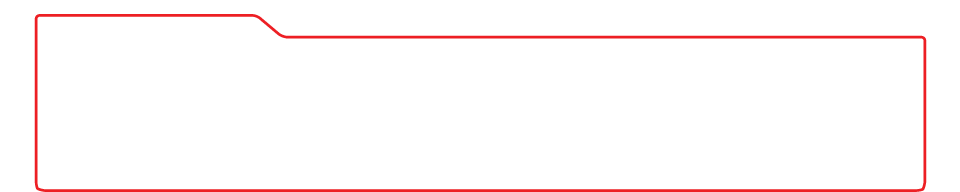
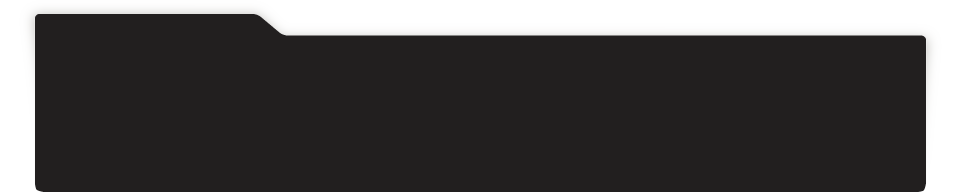
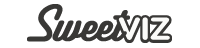
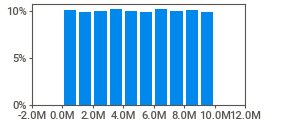
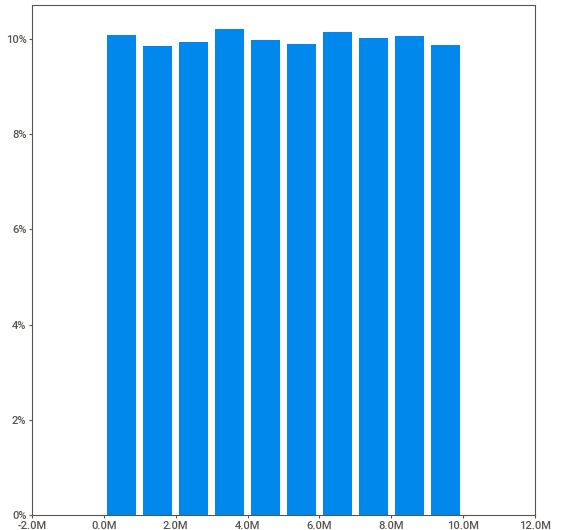
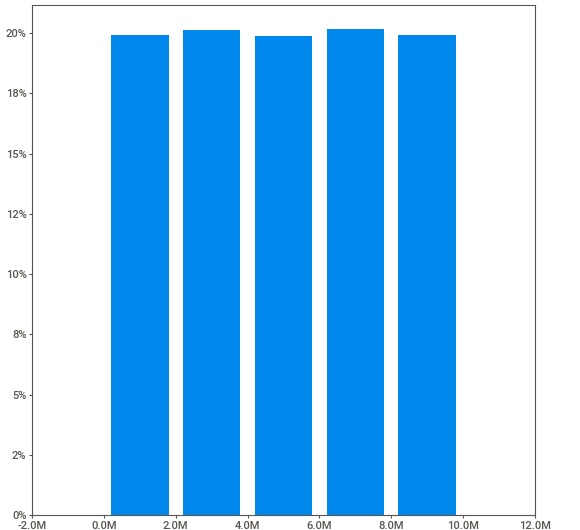
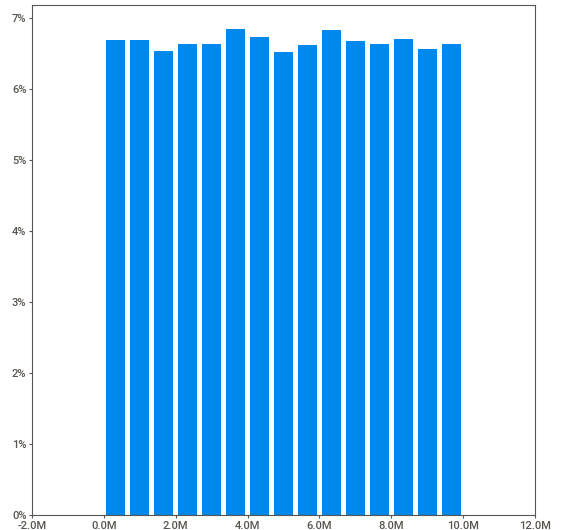
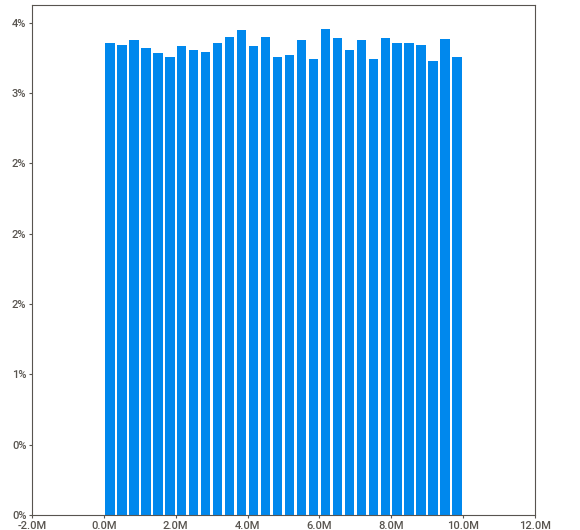
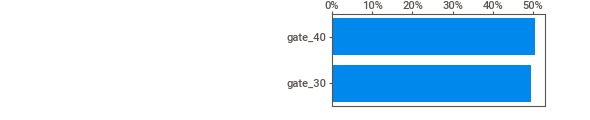
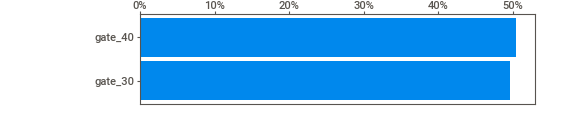
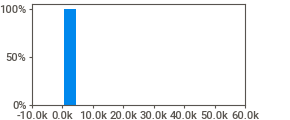
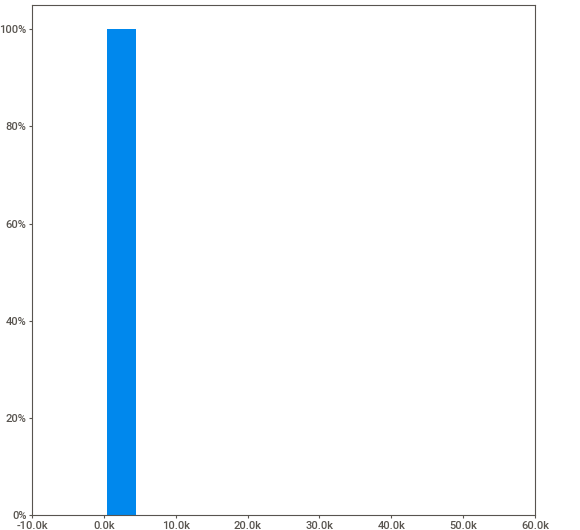
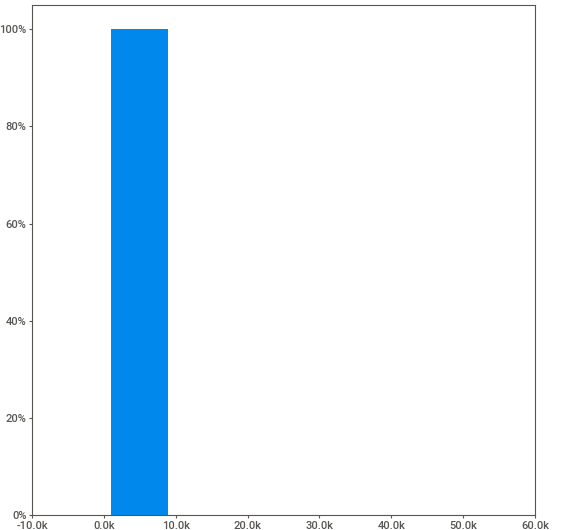
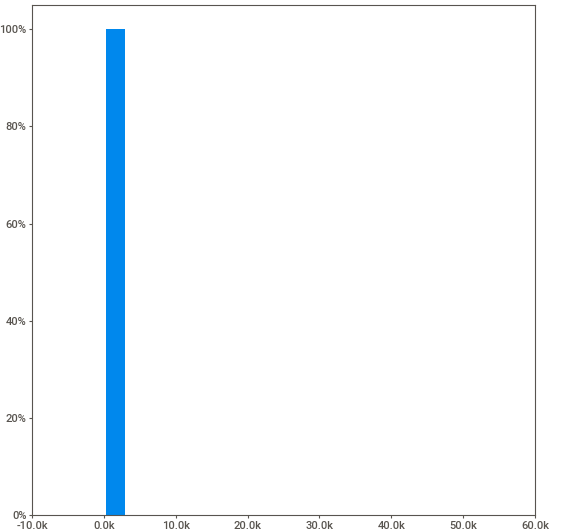
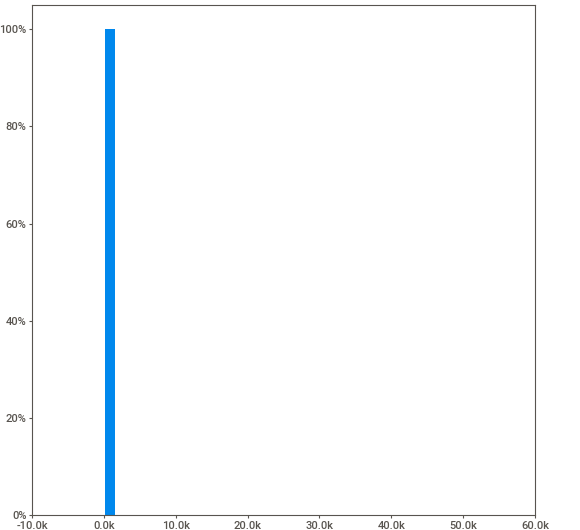
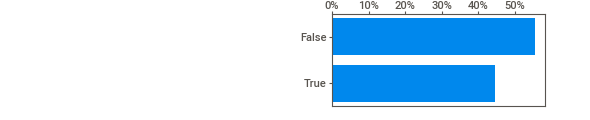
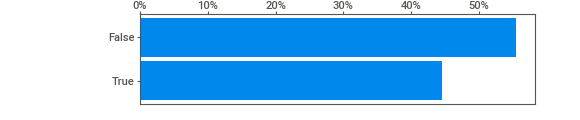
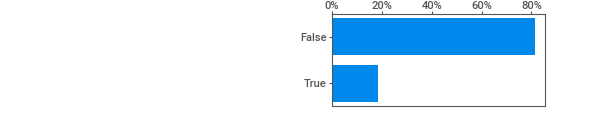
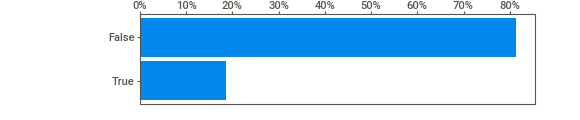
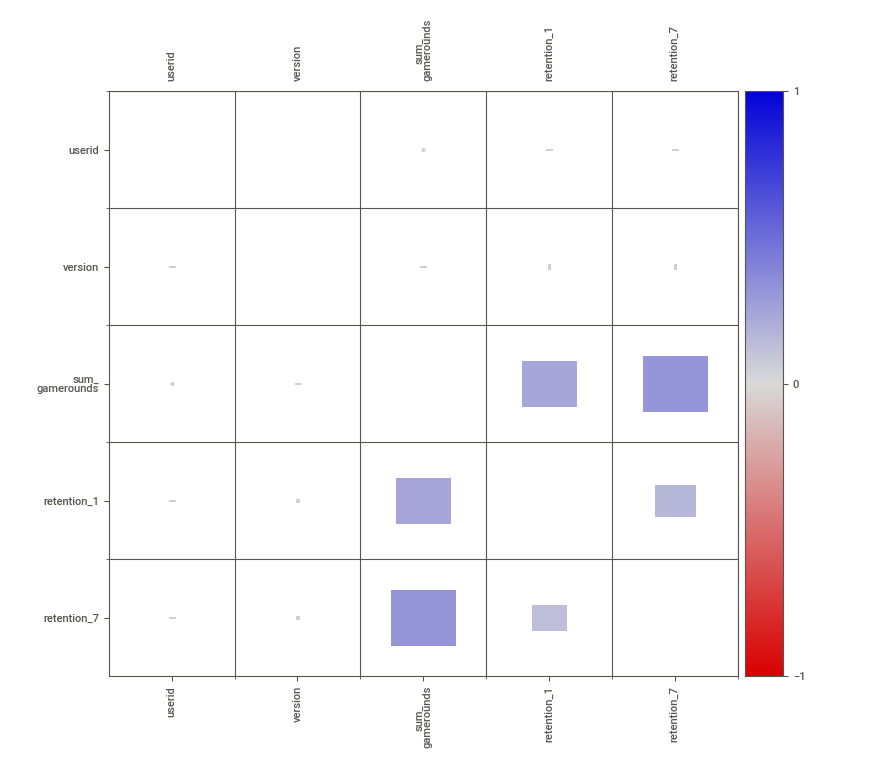
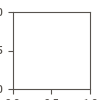

In [6]:
import sweetviz
import numpy as np
import warnings
np.warnings = warnings

my_report = sweetviz.analyze(data)
my_report.show_notebook()

In [9]:
data.sort_values(by='sum_gamerounds', ascending=False)

,userid,version,sum_gamerounds,retention_1,retention_7
57702,6390605,gate_30,49854,False,True
7912,871500,gate_30,2961,True,True
29417,3271615,gate_40,2640,True,False
43671,4832608,gate_30,2438,True,True
48188,5346171,gate_40,2294,True,True
...,...,...,...,...,...
59687,6610805,gate_30,0,False,False
23707,2639282,gate_40,0,False,False
59670,6608718,gate_30,0,False,False
59645,6604544,gate_30,0,False,False


The variable *sum_gamerounds* contains one outlier, let's get rid of the respective data sample.

In [12]:
data = data.loc[data['sum_gamerounds'] < 3000]

Let's take a look at the number of sample contained in the two testing groups.

In [15]:
data.groupby("version").userid.count()

version
gate_30    44699
gate_40    45489
Name: userid, dtype: int64

The two groups contain a similar number of samples, this is a useful feature to make them effectively comparable.

In [17]:
print("Game Rounds")
data.groupby(["version"]).sum_gamerounds.agg(["count", "median", "mean", "std", "max"]).reset_index()

Game Rounds


,version,count,median,mean,std,max
0,gate_30,44699,17,51.342111,102.057598,2961
1,gate_40,45489,16,51.298776,103.294416,2640


In [18]:
print("Retention (1 day)")
data.groupby(["version"]).retention_1.agg(["count", "median", "mean", "std", "max"]).reset_index()

Retention (1 day)


,version,count,median,mean,std,max
0,gate_30,44699,False,0.448198,0.497315,True
1,gate_40,45489,False,0.442283,0.496663,True


In [19]:
print("Retention (7 day)")
data.groupby(["version"]).retention_7.agg(["count", "median", "mean", "std", "max"]).reset_index()

Retention (7 day)


,version,count,median,mean,std,max
0,gate_30,44699,False,0.190183,0.392450,True
1,gate_40,45489,False,0.182000,0.385849,True


On the 3 analysed variables, the difference between the two groups are really small. Nevertheless, let's check it using a sound testing.

<a id='ab'></a>
<h1 style="color:DarkSlateBlue" >6. A/B Testing</h1>

### Assumptions:
- Check normality
- If Normal Distribution, check homogeneity

### Steps:
- Split & Define Control Group & Test Group
- Apply Shapiro Test for normality
- If parametric apply Levene Test for homogeneity of variances
- If Parametric + homogeneity of variances apply T-Test
- If Parametric - homogeneity of variances apply Welch Test
- If Non-parametric apply Mann Whitney U Test directly

In [23]:
from scipy.stats import shapiro
import scipy.stats as stats


def AB_Test(dataframe, group, target, A_name, B_name):
    
    dataframe[group] = dataframe[group].replace(A_name, "A")
    dataframe[group] = dataframe[group].replace(B_name, "B")

    # Split A/B
    groupA = dataframe[dataframe[group] == "A"][target]
    groupB = dataframe[dataframe[group] == "B"][target]
    
    # Assumption: Normality
    ntA = shapiro(groupA)[1] < 0.05
    ntB = shapiro(groupB)[1] < 0.05
    # H0: Distribution is Normal! - False
    # H1: Distribution is not Normal! - True
    
    if (ntA == False) & (ntB == False): # "H0: Normal Distribution"
        # Parametric Test
        # Assumption: Homogeneity of variances
        leveneTest = stats.levene(groupA, groupB)[1] < 0.05
        # H0: Homogeneity: False
        # H1: Heterogeneous: True
        
        if leveneTest == False:
            # Homogeneity
            ttest = stats.ttest_ind(groupA, groupB, equal_var=True)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
        else:
            # Heterogeneous
            ttest = stats.ttest_ind(groupA, groupB, equal_var=False)[1]
            # H0: M1 == M2 - False
            # H1: M1 != M2 - True
    else:
        # Non-Parametric Test
        ttest = stats.mannwhitneyu(groupA, groupB)[1] 
        # H0: M1 == M2 - False
        # H1: M1 != M2 - True
        
    # Result
    temp = pd.DataFrame({
        "AB Hypothesis":[ttest < 0.05], 
        "p-value":[ttest]
    })
    temp["Test Type"] = np.where((ntA == False) & (ntB == False), "Parametric", "Non-Parametric")
    temp["AB Hypothesis"] = np.where(temp["AB Hypothesis"] == False, "Fail to Reject H0", "Reject H0")
    temp["Comment"] = np.where(temp["AB Hypothesis"] == "Fail to Reject H0", "A/B groups are similar!", "A/B groups are not similar!")
    
    # Columns
    if (ntA == False) & (ntB == False):
        temp["Homogeneity"] = np.where(leveneTest == False, "Yes", "No")
        temp = temp[["Test Type", "Homogeneity","AB Hypothesis", "p-value", "Comment"]]
    else:
        temp = temp[["Test Type","AB Hypothesis", "p-value", "Comment"]]
    
    # Print Hypothesis
    print("# A/B Testing Hypothesis")
    print("H0: A == B")
    print("H1: A != B", "\n")
    
    return temp
    

In [24]:
AB_Test(dataframe=data, group = "version", target = "sum_gamerounds", A_name="gate_30", B_name="gate_40")


# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.050892,A/B groups are similar!


In [25]:
AB_Test(dataframe=data, group = "version", target = "retention_1", A_name="gate_30", B_name="gate_40")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Fail to Reject H0,0.073922,A/B groups are similar!


In [26]:
AB_Test(dataframe=data, group = "version", target = "retention_7", A_name="gate_30", B_name="gate_40")

# A/B Testing Hypothesis
H0: A == B
H1: A != B 



,Test Type,AB Hypothesis,p-value,Comment
0,Non-Parametric,Reject H0,0.001592,A/B groups are not similar!


The only feature on which the two groups are dissimilar in the 7 days retention, that we saw to be higher in the case of the gate_30 version, even if very slightly.